# Laboratorijska vježba - Obrada informacija - Neuronske mreže

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

from torchsummary import summary

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torchsummary
!pip install numpy matplotlib opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1+cu116
    Uninstalling torchaudio-0.13.1+cu116:
      Successfully uninstalled torchaudio-0.13.1+cu116
ERROR: pip's dependency resolver does no

# Zadatak 1 - Klasifikacija slike rukom pisanih znamenki

U prvom zadatku ove laboratorijske vježbe želimo analizirati utjecaj arhitekture mreže i drugih hiperparametara na uspješnost predikcije. Vaš zadatak je složiti nekoliko modela različitih karakteristika, te će te te modele istrenirati na problemu klasifikacije rukom pisanih znamenki.

Veliki dio koda koji je potreban za provođenje vježbe je dan. Vi ćete riješiti zadatak nadopunjavanjem koda. Također ste slobodni izmjeniti predloženi kod, ali ne preporuča se. Za labos je potreban Python 3.6+ i PyTorch 1.6+.

## Učitavanje podataka

Sljedeći kod priprema MNIST Dataset objekte koji dolaze s PyTorch paketom. Također instanciramo i DataLoader objekte koji rukuju sa mješanjem i batchanjem skupa podataka.

In [4]:
batch_size_train = 64
batch_size_test = 64

train_set = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                                      )


test_set = torchvision.datasets.MNIST('./files/', train=False, download=True,
                                      transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                                     )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



In [5]:
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

#### Podzadatak a)
Prikažite nekoliko primjera iz skupa za testiranje. Sliku pokažite pomoću `matplotlib` funkcije `imshow`. Neka `title` prikazane slike bude labela uzorka.

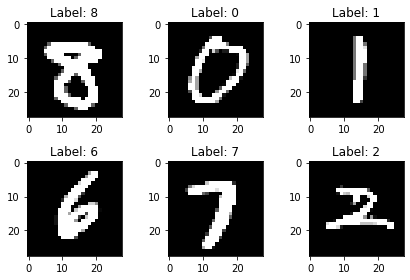

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i].squeeze().float(), cmap='gray', vmin=0, vmax=1)
    plt.title("Label: {}".format(example_targets[i]))


In [7]:
print(example_data.shape)
print(example_targets.shape)
print(batch_idx)

torch.Size([64, 1, 28, 28])
torch.Size([64])
0


## Pomoćne metode za treniranje neuronskih mreža

Nakon podzadataka ove sekcije postoji skup testova na kojima možete provjeriti točnost vaših pomoćnih funkcija. Bez točno rješenih pomoćnih funkcija ostatak labosa ne možete riješiti. 

#### Podzadatak b) - Funkcija za određivanje broja parametara PyTorch modela

Jedna od metoda usporedbe naših modela će biti po broju parametara koji čine taj model. Radi toga je potrebno napisati metodu `get_number_of_model_parameters(model)` koja za predani model `model` vraća ukupni broj parametara tog modela.
Svaki PyTorch model sadrži implementaciju metode `.parameters()` koja vraća iterator nad parametrima modela. Ti parametri su tipa `torch.nn.parameter.Parameter`, čije dimenzije možemo dobiti pomoću `.shape` propertya.
Dovrište traženu metodu.

In [8]:
def get_number_of_model_parameters(model):
    return len(list(model.parameters()))


#### Podzadatak c) - Funkcija za treniranje modela

Model se trenira u četiri koraka.

1. Izračuna se prolaz unaprijed nad jednim batchom.
2. Na temelju dobivenog izlaza i točnih labela se računa gubitak. Kako je pokazano u demonstracijskoj bilježnici, 
3. Izračunata greška se propagira unazad kroz mrežu radi računanja gradijenata.
4. Na temelju gradijenata, vrijednosti parametara i parametrima optimizatora (koji optimizator se koristi, kolika je stopa učenja, momentum i slično) se računa nova vrijednost parametara modela.

Implementirajte te korake u funkciji `train_step(train_loader, epoch, device, verbose)`.  

Napomene:
* Grešku koju trebate računati je "negative log likelihood loss", za koju PyTorch nudi implementaciju. Preporučamo da koristite gotovu implementaciju loss funkcije. 
* Računanje gradijenata pomoću propagacije greške u nazad se računa pomoću metode `.backward()`. Nad kojim elementom pozivamo tu metodu?
* Korak optimizacije se radi pomoću `.step()` metode optimizator objekta. Pretpostavite da postoji objekt `optimizer` u globalnom scopeu.
* Pripazite da Vam se gradijenti ne akumuliraju kroz više koraka optimizacije. PyTorch modeli nude metodu `.zero_grad()` koja postavlja vrijednosti svih gradijenata nekog modela na 0.


In [9]:
def train_step(network, train_loader, epoch, device, verbose=True):
    train_losses = []
    train_counter = []
    
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        
         # Forward pass through the network
        output = network(data)
        
        # Calculating loss
        loss = F.nll_loss(output, target)
        
        # Backward pass to calculate the gradients
        loss.backward()
        
        # Updating model parameters
        optimizer.step()
        
        # Reset the gradients to zero for the next iteration
        optimizer.zero_grad()


        
        if (batch_idx % log_interval == 0):
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx * len(data), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), 
                    loss.item()))
            
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    
    return train_losses, train_counter

#### Podzadatak d) - Funkcija za evaluaciju modela

Uspješnost učenja određujemo pomoću metrika točnosti. U ovoj laboratoriskoj vježbi pratimo dvije metrike - `negative log likelihood` i `accuracy`. Sa NLLLoss smo se već susreli; accuracy definiramo kao:

$ accuracy = \frac{\text{number of correctly classified samples}}{\text{total number of samples}} $

Nadopunite funkciju `test(network, test_loader, device, verbose)` tako da se model evaluira za navedene metrike.

U predloženom kodu se koristi `with torch.no_grad()`. Kako tijekom evaluacije ne mjenjamo parametre modela, gradijent nam nije potreban. Time ubrzavamo računanje (ne računa se gradijent), štedimo memoriju (izračunati gradijent se ne sprema) i spriječavamo buduće probleme (npr. ostanu gradijenti do sljedeće faze treniranja, gdje se gradijenti test seta iskoriste za učenje).

In [10]:
def test(network, test_loader, device, verbose=True):
    network.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
             
             # Forward pass through the network
            output = network(data)
            
            # Calculating loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            
            # Get the predicted class
            pred = output.argmax(dim=1, keepdim=True)  
            
            # Checking if the predicted class is correct
            correct += pred.eq(target.view_as(pred)).sum().item()

            
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    if verbose:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%)\n'.format(
            test_loss, 
            correct, 
            len(test_loader.dataset),
            accuracy))
    
    accuracy = torch.tensor(accuracy)
    return test_loss, accuracy.item()

U sljedećoj fazi laboratorijske vježbe izvršavamo eksperimente, spremamo rezultate i uspoređujemo. Rezultate ćemo spremati u mapi `results`, tako da će `key` mape biti naziv eksperimenta, a vrijednost će biti `tuple` koji sadrži vrijednosti po kojima se model uspoređuje.

In [11]:
results = dict()

#### Podzadatak e) - Funkcija za provođenje cijelokupnog eksperimenta nad jednim modelom

Sada je vrijeme da se koraci iz prethodnih podzadataka objedine. Funkcija `train_network(network, train_loader, test_loader, device)` radi po sljedećem principu:

* Pretpostavlja se da u globalnom scopeu postoji varijabla imena `n_epochs` koja nam govori koliko epoha će se eksperiment izvršavati
* Liste `train_losses` i `test_losses` skupljaju loss vrijednosti tijekom treniranja, dok `train_counter` i `test_counter` skupljaju trenutke u kojima se metrika zabilježila (drugim riječima, to su X i Y os na grafu "loss po vremenu") 
* prije samog treniranja se vrši testiranje modela, da se utvrdi performansa slučajnog modela
* U svakoj epohi se model trenira, testira i rezultati se zapisuju u odgovarajuće liste
* Funkcija vraća te liste na kraju

In [12]:
def train_network(network, train_loader, test_loader, device='cpu'):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    # Training for the first epoch
    new_train_losses, new_train_counter = train_step(network, train_loader, 1, device)
    train_losses.extend(new_train_losses)
    train_counter.extend(new_train_counter)

    # Testing on the test set
    test_loss, test_accuracy = test(network, test_loader, device)
    test_losses.append(test_loss)

    for epoch in range(1, n_epochs + 1):
        # Training for new epoch
        new_train_losses, new_train_counter = train_step(network, train_loader, epoch+1, device)
        
        train_losses.extend(new_train_losses)
        train_counter.extend(new_train_counter)
        test_loss, test_accuracy = test(network, test_loader, device)
        test_losses.append(test_loss)
        
    return train_losses, train_counter, test_losses, test_counter, test_accuracy

#### Testovi za utvrđivanje točnosti rada pomoćnih funkcija

Sljedeći kod služi kao pomoć za provjeru ispravnosti gore traženih pomoćnih funkcija. Generira se dataset u dva odvojena skupa, i cilj je naučiti model koji klasificira iz kojeg skupa točka dolazi. Prvo generiramo podatke i slažemo DataLoader:

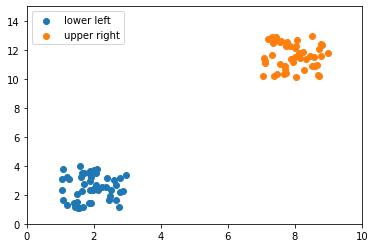

In [13]:
data_x = np.hstack([np.random.uniform(1, 3, 50), np.random.uniform(7, 9, 50)])
data_y = np.hstack([np.random.uniform(1, 4, 50), np.random.uniform(10, 13, 50)])
labels = [0 if x < 50 else 1 for x in range(0, 100)]

for idx, unique_label in enumerate(["lower left", "upper right"]):
    if idx == 0:
        plt.scatter(data_x[0:50], data_y[0:50], label=unique_label)
    if idx == 1:
        plt.scatter(data_x[50:], data_y[50:], label=unique_label)
        
plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 15)


tensor_x = torch.Tensor(np.dstack([data_x, data_y]).reshape(100, 2).astype(np.float32))
tensor_y = torch.Tensor(labels).to(dtype=torch.int64)

toy_dataset = TensorDataset(tensor_x, tensor_y)
toy_dataloader = DataLoader(toy_dataset, batch_size=1, shuffle=True)

In [14]:
toy_dataloader

Nakon toga definiramo naš model. U ovom slučaju je model dvoslojna mreža sa dva potpuno povezana sloja. 

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

Podešavamo parametre koje naše pomoćne funkcije očekivaju, te instanciramo model i optimizator.

In [16]:
n_epochs = 30
learning_rate = 0.01
log_interval = 33

network = Net().to('cpu')
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

I sada možemo trenirati naš model. Vaše funkcije su ispravne ako točnost doesgne 100% (ili barem jako blizu). **Bez ispravnih pomoćnih funkcija nećete moći riješiti ostatak labosa.**

In [17]:
train_network(network, toy_dataloader, toy_dataloader, 'cpu')

Train Epoch:     1 [    0/  100 ( 0%)]	Loss: 0.570763
Train Epoch:     1 [   33/  100 (33%)]	Loss: 0.587111
Train Epoch:     1 [   66/  100 (66%)]	Loss: 0.592709
Train Epoch:     1 [   99/  100 (99%)]	Loss: 0.165661

Test set: Avg. loss: 0.5286, Accuracy:    65/  100 (65.00%)

Train Epoch:     2 [    0/  100 ( 0%)]	Loss: 0.814574
Train Epoch:     2 [   33/  100 (33%)]	Loss: 0.265434
Train Epoch:     2 [   66/  100 (66%)]	Loss: 0.416448
Train Epoch:     2 [   99/  100 (99%)]	Loss: 0.740487

Test set: Avg. loss: 0.4895, Accuracy:    97/  100 (97.00%)

Train Epoch:     3 [    0/  100 ( 0%)]	Loss: 0.132845
Train Epoch:     3 [   33/  100 (33%)]	Loss: 0.552470
Train Epoch:     3 [   66/  100 (66%)]	Loss: 0.592574
Train Epoch:     3 [   99/  100 (99%)]	Loss: 0.855247

Test set: Avg. loss: 0.5064, Accuracy:   100/  100 (100.00%)

Train Epoch:     4 [    0/  100 ( 0%)]	Loss: 0.848654
Train Epoch:     4 [   33/  100 (33%)]	Loss: 0.792975
Train Epoch:     4 [   66/  100 (66%)]	Loss: 0.345806
Tra

([0.5707630515098572,
  0.5871106386184692,
  0.5927091240882874,
  0.16566137969493866,
  0.8145738840103149,
  0.265434205532074,
  0.4164482653141022,
  0.740487277507782,
  0.13284505903720856,
  0.5524699091911316,
  0.5925735831260681,
  0.8552466630935669,
  0.8486543893814087,
  0.7929750680923462,
  0.34580644965171814,
  0.27647894620895386,
  0.17096726596355438,
  0.9085882902145386,
  0.8793303966522217,
  0.8956729173660278,
  0.6270121932029724,
  0.13106422126293182,
  0.5330363512039185,
  0.9000122547149658,
  0.23473799228668213,
  0.9010282754898071,
  0.16747991740703583,
  0.9102565050125122,
  0.07736685872077942,
  0.2561364471912384,
  0.851191520690918,
  0.11808604747056961,
  0.9180642366409302,
  0.0500759556889534,
  0.12278556078672409,
  0.5194291472434998,
  0.09451573342084885,
  0.09941427409648895,
  0.9187794923782349,
  1.0406193733215332,
  0.1003272533416748,
  0.2161073535680771,
  0.9250528812408447,
  0.9374920725822449,
  0.9301068782806396,


## Provođenje eksperimenata i analiza rezultata

#### Podzadatak f) - Eksperimenti

Sljedeća faza labosa je korištenje naših funkcija u okviru eksperimenata. Potrebno je testirati sljedeće modele:

* **Plitki model sa uskim slojevima**
    * Model je plitak po tome što nema puno slojeva (ne ide u dubinu) i uzak po tome što sami slojevi nemaju veliki broj elemenata (npr. 1 sloj sa 100 neurona umjesto 10 slojeva sa 10 neurona)
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x10
        * Dropout (za regularizaciju)
        * Max pooling
        * ReLU aktivacija
        * Potpuno povezani sloj sa 20 neurona, ReLU aktivacija
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `shallow_and_narrow_{stopa učenja}`
* **Plitki model sa širokim slojevima**
    * Ovaj model također nema puno slojeva, ali ti slojevi imaju puno elemenata
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x40
        * Dropout (za regularizaciju)
        * Max pooling
        * ReLU aktivacija
        * Potpuno povezani sloj sa 64 neurona, ReLU aktivacija
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `shallow_and_wide_{stopa učenja}`
* **Duboki model sa uskim slojevima**
    * Ovaj model ima puno slojeva, ali su ti slojevi ograničeni u svojoj širini
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x10, ReLU aktivacijska funkcija
        * Max pooling
        * Konvolucijski sloj 5x5x20, ReLU aktivacijska funkcija
        * Max pooling
        * Potpuno povezani sloj sa 64 neurona, ReLU aktivacija
        * Dropout (za regularizaciju)
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `deep_and_narrow_{stopa učenja}`
* **Duboki model sa širokim slojevima**
    * Model koji ima sve komponente dobro (ili previše?) zastupljene.
    * Arhitektura modela je sljedeća:
        * Konvolucijski sloj 5x5x32, ReLU aktivacijska funkcija
        * Max pooling
        * Konvolucijski sloj 5x5x64, ReLU aktivacijska funkcija
        * Max pooling
        * Potpuno povezani sloj sa 50 neurona, ReLU aktivacija
        * Dropout (za regularizaciju)
        * Potpuno povezani sloj za klasifikaciju u 10 klasa, log softmax aktivacijska funkcija
    * U `results` mapi se sprema pod ključem `deep_and_wide_{stopa učenja}`


Implementirajte `.__init__(self)` i `.forward(self, x)` metode za svaki od opisanih modela, trenirajte ih, evaluirajte i spremite metrike. **Ponovite taj postupak za 3 različite stope učenja: 0.0000001, 0.01 i 1.**

Sve potrebne slojeve za ostvarenje navedenih modela možete pronaći u torch.nn modulu. Detalje možete pronaći u službenoj PyTorch dokumentaciji: https://pytorch.org/docs/stable/index.html 

**Spremite si najbolji model. Biti će potreban u podzadatku h)**.

Prvo je potrebno podesiti parametre. Parametri su sljedeći:
* n_epochs - broj epoha eksperimenta
* learning_rate - stopa učenja
* log_interval - broj koraka između dva ispisa tijekom treniranja (ispis se dešava samo ako se funkcija poziva s argumentom verbose=True)
* device - oznaka na kojem se uređaju izvršava eksperiment; "cuda" za GPU, "cpu" za CPU

In [125]:
n_epochs = 3
learning_rate = 0.0001
log_interval = 100
device = 'cuda'

Naš model definiramo u klasi "Net" koja nasljeđuje nn.Module. Nadjačajte metode `__init__(self)` i `forward(self, x)` kako je opisano u tekstu zadatka.

In [116]:
#shallow_narrow
class Net1(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(10*12*12, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.dropout(x, training = self.training)
        x = x.view(-1, 10*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [120]:
#shallow_wide
class Net2(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(40*12*12, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = F.dropout(x, training = self.training)
        x = x.view(-1, 40*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [139]:
#deep_narrow
class Net3(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(10, 25, 5)  #5x5x25
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(25*4*4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 25*4*4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [127]:
#deep_wide
class Net4(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 5) 
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Da bi trenirali naš model, potrebno je napraviti instancu mreže i optimizatora. Koristite Stohastic Gradient Descent optimizator iz torch.optim modula. Detalji se mogu pronaći u službenoj dokuemntaciji PyTorcha za optim modul: https://pytorch.org/docs/stable/optim.html

In [140]:
#CUDA is not available
device = 'cpu'
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)


Iskoristimo našu pripremljenu funkciju za izvođenje eksperimenta:

In [129]:
train_losses, train_counter, test_losses, test_counter, test_accuracy = train_network(network, train_loader, test_loader, device)

Train Epoch:     1 [    0/60000 ( 0%)]	Loss: 2.304215
Train Epoch:     1 [ 6400/60000 (11%)]	Loss: 2.322809
Train Epoch:     1 [12800/60000 (21%)]	Loss: 2.322682
Train Epoch:     1 [19200/60000 (32%)]	Loss: 2.282442
Train Epoch:     1 [25600/60000 (43%)]	Loss: 2.291109
Train Epoch:     1 [32000/60000 (53%)]	Loss: 2.276059
Train Epoch:     1 [38400/60000 (64%)]	Loss: 2.266811
Train Epoch:     1 [44800/60000 (75%)]	Loss: 2.280913
Train Epoch:     1 [51200/60000 (85%)]	Loss: 2.275471
Train Epoch:     1 [57600/60000 (96%)]	Loss: 2.280291

Test set: Avg. loss: 2.2579, Accuracy:  2150/10000 (21.50%)

Train Epoch:     2 [    0/60000 ( 0%)]	Loss: 2.257065
Train Epoch:     2 [ 6400/60000 (11%)]	Loss: 2.261903
Train Epoch:     2 [12800/60000 (21%)]	Loss: 2.262595
Train Epoch:     2 [19200/60000 (32%)]	Loss: 2.265421
Train Epoch:     2 [25600/60000 (43%)]	Loss: 2.251772
Train Epoch:     2 [32000/60000 (53%)]	Loss: 2.212819
Train Epoch:     2 [38400/60000 (64%)]	Loss: 2.236204
Train Epoch:     2 [

Spremimo rezultate u mapu `results` kako je navedeno u zadatku. Također nam je potreban broj parametara mreže, što možemo izračunati u ovom koraku.

In [130]:
number_of_parameters = get_number_of_model_parameters(network)
#results[f'shallow_and_narrow_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)
#results[f'shallow_and_wide_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)
results[f'deep_and_narrow_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)
#results[f'deep_and_wide_{learning_rate}'] = (train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters)

Prikažimo rezultate za ovaj eksperiment:

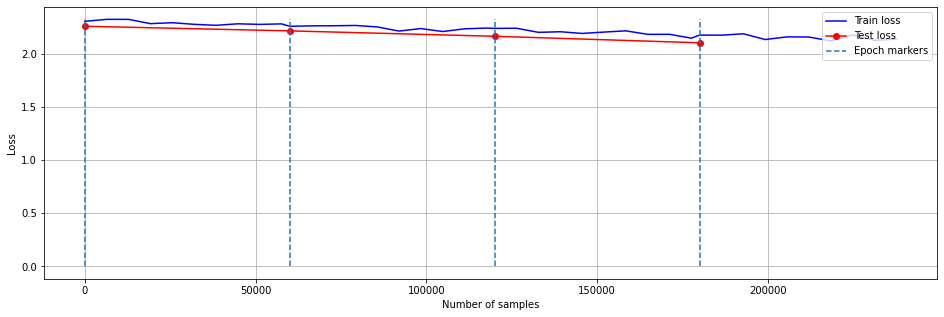

In [131]:
fig = plt.figure(figsize=(16, 5))
plt.plot(train_counter, train_losses, color='blue', label='Train loss')
plt.plot(test_counter, test_losses, color='red',  marker='o', label='Test loss')
plt.vlines(test_counter, 0, max(train_losses + test_losses), linestyles='dashed', label='Epoch markers')

plt.legend(loc='upper right')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.grid()

**Nadopunite bilježnicu sa svim traženim arhitekturama i learning rateovima zadanim u ovom podzadatku.** 

#### Podzadatak g) - Usporedba rezultata

Nakon što smo izvršili sve eksperimente potrebno ih je usporediti. Nacrtajte tražene grafove, te pomoću njih odgovorite na pitanja postavljena na Moodleu.

Nacrtajte graf gdje je X os vrijeme (odgovara na pitanje: koji korak treniranja?), a Y os je loss za **trening** skup podataka.

Odgovorite na sljedeća pitanja:
1. Radi li se o konzistentnom padu iz koraka u korak?
2. Jesu li neke arhitekture u startu značajno bolje od drugih?
3. Koji model je najnestabilniji tijekom treniranja?

Text(0.5, 0, 'Steps')

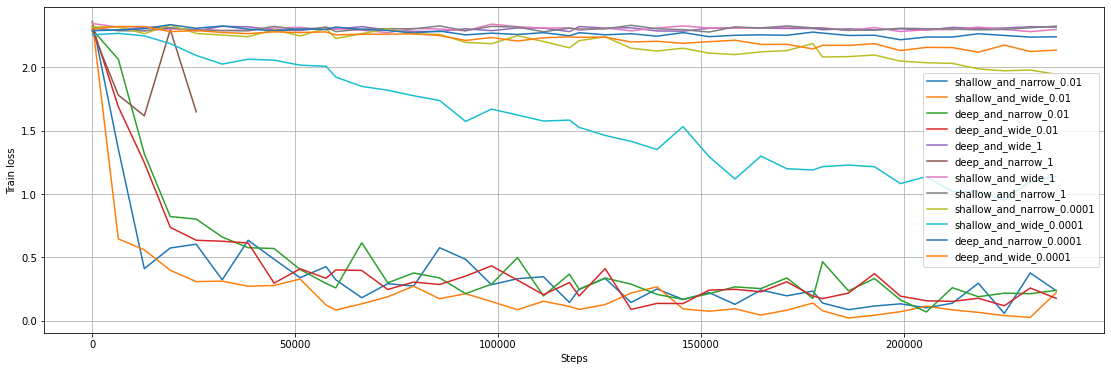

In [132]:
plt.figure(figsize=(19, 6))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.plot(train_counter, train_losses, label=model_key)

plt.legend()
plt.grid()
plt.ylabel("Train loss")
plt.xlabel("Steps")

Nacrtajte graf gdje je X os vrijeme (odgovara na pitanje: koji korak treniranja?), a Y os je loss za **test** skupu podataka.

Odgovorite na sljedeća pitanja:
4. Radi li se o konzistentnom padu iz koraka u korak?
5. Jesu li neke arhitekture u startu značajno bolje od drugih?

Text(0, 0.5, 'Steps')

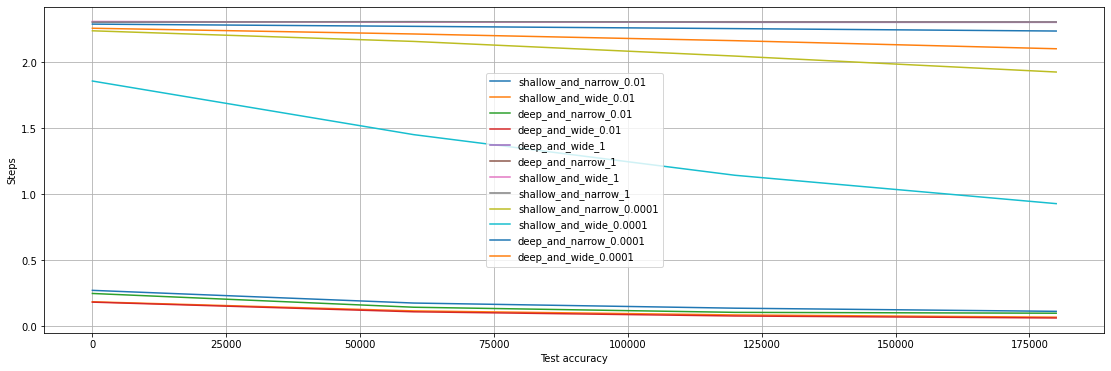

In [133]:
plt.figure(figsize=(19, 6))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.plot(test_counter, test_losses, label=model_key)

plt.legend()
plt.grid()
plt.xlabel("Test accuracy")
plt.ylabel("Steps")

Nacrtajte graf (scatter plot) gdje je X os broj parametara modela, a Y os je točnost koju model ostvaruje na test skupu.

Odgovorite na sljedeća pitanja:
6. Koji je najbolji model?
7. Kakvi su duboki modeli u usporedbu s plitkim modelima?
8. Kakvi su široki modeli u usporedbi s uskima?

Text(0.5, 0, 'Number of parameters')

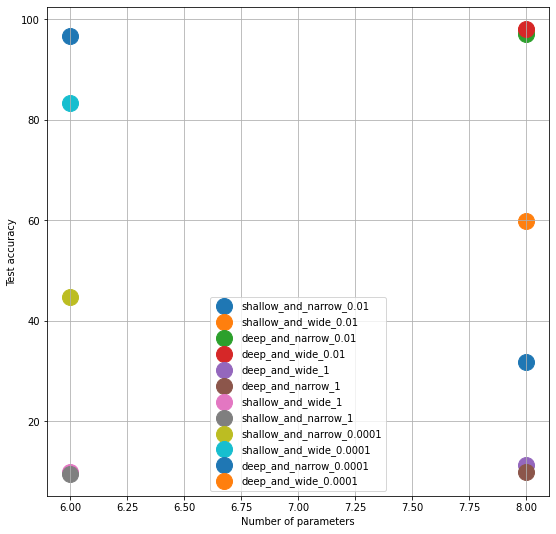

In [134]:
plt.figure(figsize=(9, 9))

for model_key in results:
    train_counter, train_losses, test_counter, test_losses, test_accuracy, number_of_parameters = results[model_key]
    plt.scatter(number_of_parameters, test_accuracy, label=model_key, s=256)

plt.legend()
plt.grid()
plt.ylabel("Test accuracy")
plt.xlabel("Number of parameters")

#### Podzadatak h) - Evaluacija na neviđenom skupu podataka

Preuzmite skup podataka za ocjenjivanje sa sljedeće poveznice: http://zver6.zesoi.fer.hr:18080/labos_oi/submission_z1.zip

Primjer filea kojeg treba generirati možete preuzeti sa: http://zver6.zesoi.fer.hr:18080/labos_oi/zad1_submission_sample.csv 

Odredite predikcije Vašeg najboljeg modela nad tim skupom, te ih stavite na Moodle.

## Zadatak 2 - Pronalazak znamenki na slici i klasifikacija pronađene znamenke 

Drugi zadatak je proširenje naučenog u prvom zadatku. Problem se proširuje - umjesto klasifikacije rukom pisane znamenke, naš problem je sada pronalazak rukom pisane znamenke na slici **i** klasifikacija.

Kao i u prethodnoj vježbi, dani su dijeli koda potrebnog za ostvarenje vježbe, a na Vama je da nadopunite dijelove koji nedostaju.

#### Skup podataka

Da bi mogli trenirati model za klasifikaciju i detekciju objekta na slici, moramo imati odgovarajući dataset. Koristimo postojeći MNIST dataset, a modificiramo ga tako da postavimo originalni MNIST uzorak na slučajnu poziciju na praznoj slici. Sljedeći kod generira takve uzorke, vraćajući modificiranu sliku, oznaku kategorije i poziciju znamenke na slici (*bounding box*).

In [135]:
class PositionMNIST(Dataset):
    
    def __init__(self, image_size=128, transform=None, train_set=False):
        self.image_size = image_size
        self.transform = transform
        
        self.set = torchvision.datasets.MNIST('./files/', train=train_set, download=True)
        self.position_cache = [-1] * len(self.set)
    
    def __len__(self):
        return len(self.set)

    def __getitem__(self, idx):
        if self.position_cache[idx] == -1:
            x_pos = int(np.random.uniform(0, self.image_size-29))
            y_pos = int(np.random.uniform(0, self.image_size-29))
            self.position_cache[idx] = (x_pos, y_pos)
            
        x_pos, y_pos = self.position_cache[idx]
        
        canvas = np.zeros((self.image_size, self.image_size, 1), dtype=np.uint8)
        canvas[y_pos:(y_pos+28), x_pos:(x_pos+28), 0] = self.set[idx][0]
        
        x_pos = float(x_pos)
        y_pos = float(y_pos)
        
        if self.transform is not None:
            canvas = self.transform(canvas)
        
        return canvas, self.set[idx][1], (x_pos, y_pos, x_pos+28, y_pos+28)

In [136]:
batch_size_train = 128
batch_size_test = 128
image_size = 128

train_set = PositionMNIST(train_set=True, image_size=image_size, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

test_set = PositionMNIST(train_set=False, image_size=image_size, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

In [137]:
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

#### Podzadatak a) - Vizualizacija podataka

Uzmite jedan uzorak pomoću data loadera i vizualizirajte ga. Neka u titleu piše klasa i lokacija.

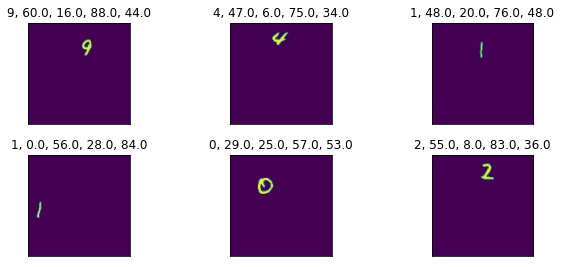

In [138]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_label, example_positions) = next(examples)
fig = plt.figure(figsize=(9, 4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    # ----- 
    plt.imshow(example_data[i][0])
    plt.title(f"{example_label[i]}, {example_positions[0][i]}, {example_positions[1][i]}, {example_positions[2][i]}, {example_positions[3][i]}")
    # -----
    plt.xticks([])
    plt.yticks([])


#### Podzadatak b) - Pomoćne funkcije za treniranje

Nadopunite pomoćne funkcije za treniranje neuronskih mreža po principu naučenom u 1. zadatku. Temeljna razlika između pomoćne funkcije iz prethodnog zadatke i pomoćne funkcije u ovom zadatku je:

1. Rukovanje s podacima (ovdje ih ima više)
2. Drugi problem rješavamo, stoga trebamo drugačiju loss funkciju.

Loss funkcija će se u ovom slučaju sastojati od dva dijela - loss za klasifikaciju s kojim smo se već upoznali, i prosječan kvadrat greške (*mean squared error*) za određivanje pozicije. Loss će se računa kao:

$ \mathcal{L} = \text{NLLLoss}(\text{classification output}, \text{target)} + \frac{(x_1 - \hat{x}_1)^2 + (y_1 - \hat{y}_1)^2 + (x_2 - \hat{x}_2)^2 + (y_2 - \hat{y}_2)^2}{128 \cdot 128}  $

Pri čemu su $x$ i $y$ točne pozicije objekta na slici, a $\hat{x}$ i $\hat{y}$ su modelom određene pozicije objekta.


In [143]:
def position_loss_fn(output, position):
    loss_mse = 0
    for i in range(position[1].shape[0]):
      loss_mse += ((position[0][i]-output[1][i])**2 + (position[1][i]-output[2][i])**2 + (position[2][i]-output[3][i])**2 + (position[3][i]-output[4][i])**2) / (128.*128.)
    return loss_mse / i 

In [144]:
def train_step(train_loader, epoch, device, verbose=True):
    train_losses = []
    train_counter = []
    
    network.train()
    
    for batch_idx, (data, target, position) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        # ----- 
        optimizer.zero_grad()
        output = network(data)

        class_loss = F.nll_loss(output, target)
        position_loss = position_loss_fn(output, position)
        loss = class_loss + position_loss
        loss.backward()
        optimizer.step()
        # -------
        
        if batch_idx % log_interval == 0:
            if verbose:
                print('Train Epoch: {:5d} [{:5d}/{:5d} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx * len(data), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), 
                    loss.item()))
                
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
    return train_losses, train_counter

Po istom principu iz 1. zadatka nadopunite funkciju za evaluaciju modela. U ovom slučaju mjerimo 3 stvari: sam loss, točnost klasifikacije i posebno loss za detekciju.

In [157]:
def test(test_loader, device, verbose=True):
    network.eval()
    
    test_loss_clsf = 0
    test_loss_bbox = 0
    correct = 0
    with torch.no_grad():
        for data, target, position in test_loader:
            data = data.to(device)
            target = target.to(device)

            # ---- 
            output, classification_output, position_output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            position_loss += F.mse_loss(position_output, position, reduction='sum').item()
            pred = classification_output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # ----------
            
    test_loss_clsf /= len(test_loader.dataset)
    test_loss_bbox /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    
    if verbose:
        print('\n[Test] Classification: Avg. loss: {:.4f}, Accuracy: {:5d}/{:5d} ({:2.2f}%) | Object detection: Avg. loss: {:.4f}\n'.format(
            test_loss_clsf, 
            correct, 
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset), 
            test_loss_bbox))
    
    return test_loss_clsf, test_accuracy, correct, test_loss_bbox

Pomoćna funkcija za provođene eksperimenata iz prethodnog zadatka je iskoristiva do na praćenje dodatnih metrika. Proširite tu funkciju za ovaj zadatak.

In [158]:
def train_network(network, train_loader, test_loader, device='cpu'):
    train_losses = []
    train_counter = []
    test_losses_clsf = []
    test_accuracies = []
    test_losses_bbox = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    # -----
    (test_loss_clsf, test_accuracy, correct, test_loss_bbox) = test(test_loader, device)
    test_losses_clsf.append(test_loss_clsf)
    test_accuracies.append(test_accuracy)
    test_losses_bbox.append(test_loss_bbox)
    # ----------

    for epoch in range(1, n_epochs + 1):
        # ---------
        (new_train_losses, new_train_counter) = train_step(train_loader, epoch, device)
        (test_loss_clsf, test_accuracy, correct, test_loss_bbox) = test(test_loader, device)
        train_losses.extend(new_train_losses)
        train_counter.extend(new_train_counter)
        test_losses_clsf.append(test_loss_clsf)
        test_accuracies.append(test_accuracy)
        test_losses_bbox.append(test_loss_bbox)
        # ---------
        
    # --------- 
    test_losses_total = []
    test_losses_new = []
    i = 0
    for loss in test_losses_clsf:
      test_losses_new.append(loss + test_losses_bbox[i])
      i = i + 1
    test_losses_total.append(test_losses_new)
    # -----------
    
    return train_losses, train_counter, test_losses_clsf, test_accuracies, test_losses_bbox, test_counter

## Provođenje eksperimenata i analiza rezultata

#### Podzadatak c) - Izrada modela koji točno klasificira i locira objekt na slici

Kao i u prethodnom zadatku, prvo je potrebno podesiti parametre. Parametri su isti, no ponovimo:
* n_epochs - broj epoha eksperimenta
* learning_rate - stopa učenja
* log_interval - broj koraka između dva ispisa tijekom treniranja (ispis se dešava samo ako se funkcija poziva s argumentom verbose=True)
* device - oznaka na kojem se uređaju izvršava eksperiment; "cuda" za GPU, "cpu" za CPU

In [159]:
n_epochs = 3
learning_rate = 0.0005
momentum = 0.9
log_interval = 100
device = 'cpu'

Temeljna razlika u arhitekturi modela ovog zadatka i arhitekture modela iz prethodnog zadatka je broj izlaza. Prošla neuronska mreža je imala 10 izlaznih neurona - svaki za jednu klasu. Ova neuronska mreža ima 14 izlaza - 10 za svaku klasu za klasifikacijski problem i 4 za svaku koordinatu rezultirajućeg bounding boxa objekta.

Na temelju iskustva iz 1. zadatka, nadopunite sljedeći model da bi riješili problem:

In [164]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()
        self.image_size = image_size
        
        # --------
        # Ovdje je dan primjer jednog ulaznog conv sloja i oblika izlaznih slojeva za orijentaciju
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.class_fc1 = nn.Linear(in_features=3136, out_features=240)
        self.drop = nn.Dropout(0.1)
        self.class_fc2 = nn.Linear(in_features=240, out_features=120)

        self.class_out = nn.Linear(in_features=120, out_features=10)

        self.obj_x1 = nn.Linear(4, 1)
        self.obj_y1 = nn.Linear(4, 1)
        self.obj_x2 = nn.Linear(4, 1)
        self.obj_y2 = nn.Linear(4, 1)

        self.obj_x1_out = nn.Linear(1, 1)
        self.obj_y1_out = nn.Linear(1, 1)
        self.obj_x2_out = nn.Linear(1, 1)
        self.obj_y2_out = nn.Linear(1, 1)
        # --------

    def forward(self, x):
        # ---- ovdje nadopunite ostatak mreže
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
      
        x = nn.Flatten(1, -1)(x)

        c = F.relu(self.class_fc1(x))
        c = self.drop(c)
        c = F.relu(self.class_fc2(c))
        c = F.relu(self.class_out(c))

        x = F.relu(self.box_fc1(x))
        x = F.relu(self.box_fc2(x))
        x = F.relu(self.box_out(x))
        
        x1 = F.relu(self.obj_x1(x))
        y1 = F.relu(self.obj_y1(x))
        x2 = F.relu(self.obj_x2(x))
        y2 = F.relu(self.obj_y2(x))
        # -------- izlaz za klasifikaciju
        clsf = F.log_softmax(x, dim=1)

        # -------- izlaz za detekciju
        x1 = F.relu(self.obj_x1_out(x1))
        y1 = F.relu(self.obj_y1_out(y1))
        x2 = F.relu(self.obj_x2_out(x2))
        y2 = F.relu(self.obj_y2_out(y2))
        
        return clsf, x1.squeeze(), y1.squeeze(), x2.squeeze(), y2.squeeze()

In [161]:
number_of_params = get_number_of_model_parameters(network)
print("Broj parametara u modelu:", number_of_params)

Broj parametara u modelu: 26


In [165]:
network = Net(image_size).to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [166]:
train_losses, train_counter, test_losses_clsf, test_accuracies, test_losses_bbox, test_counter = train_network(network, train_loader, test_loader, device)

RuntimeError: ignored

**Vizualizacija metrika uspješnosti**

Vizualizirajte si sve metrike na sljedećem grafu: train_losses, test_losses_total, test_losses_clsf i test_losses_bbox. Pripazite što vam je na x osi!

In [ ]:
test_losses_total = np.array(test_losses_clsf) + np.array(test_losses_bbox)

fig = plt.figure(figsize=(32, 7))
# ---- 

# ----------

plt.legend(loc='upper right')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.grid()

#### Vizualni pregled - što model estimira?

Iskorisite sljedeći kod da bi vidjeli kako izgledaju predikcije Vašeg modela.

In [ ]:
with torch.no_grad():
    clsf_out, x1_out, y1_out, x2_out, y2_out = network(example_data.to(device))

plt.figure(figsize=(32, 32))
for idx in range(0, example_data.shape[0]):
    image = np.array(example_data[idx, 0, ...]).copy()

    x1, y1, x2, y2 = list(map(lambda x: int(x.item()), [x1_out[idx, ...], y1_out[idx, ...], x2_out[idx, ...], y2_out[idx, ...]]))
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (2.5), 2)

    plt.subplot(12, 12, idx+1)
    plt.imshow(image)
    plt.title(np.argmax(clsf_out[idx, ...].cpu()))
    plt.xticks([])
    plt.yticks([])

#### Podzadatak d) - Evaluacija na neviđenom skupu podataka

Preuzmite skup podataka za ocjenjivanje sa sljedeće poveznice: http://zver6.zesoi.fer.hr:18080/labos_oi/submission_z2.zip

Primjer filea kojeg treba generirati možete preuzeti sa: http://zver6.zesoi.fer.hr:18080/labos_oi/zad2_submission_sample.csv 

Odredite predikcije Vašeg najboljeg modela nad tim skupom, te ih stavite na Moodle.